In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib

In [2]:
data_NASDAQ  = yf.download('^IXIC', start='2010-01-01', end='2023-05-01')
data_NSE = yf.download('^NSEI', start='2010-01-01', end='2023-05-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<h3>Calculating Correlation Coefficient</h3>

In [5]:
df = pd.DataFrame()
df=pd.concat([data_NASDAQ['Adj Close'],data_NSE['Adj Close']],axis=1)
df.columns=['NASDAQ','NSE']
df.dropna(inplace=True)
corrcoeff = df['NASDAQ'].corr(df['NSE'])
print("Correlation Coefficient between NASDAQ and NSE is: ",corrcoeff)

Correlation Coefficient between NASDAQ and NSE is:  0.9513138758576779


The indidices are positively correlated and correlation is strong since the coefficient is high.

<h3>Lead Lag Relationship</h3>

In [20]:
lags = np.arange(-200,200,1)
lags
correlations = []
for lag in lags :
    shifted_nasdaq = df['NASDAQ'].shift(lag)
    correlation = df['NSE'].corr(shifted_nasdaq)
    correlations.append(correlation)

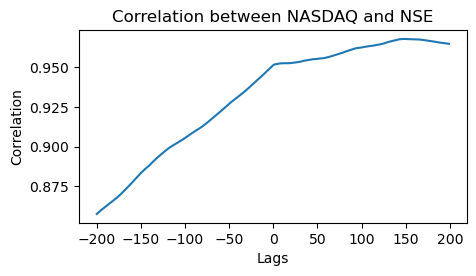

In [21]:
plt.figure(figsize=(5,2.5))
plt.plot(lags,correlations)
plt.title('Correlation between NASDAQ and NSE')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [22]:
max_correlation = max(correlations)
best_lag = lags[correlations.index(max_correlation)]
print("Best lag is: ",best_lag)
print("Max correlation is: ",max_correlation)

Best lag is:  148
Max correlation is:  0.9677174313611793


The best lag is 148. This means, when NSE was 148 days behind NASDAQ, the correlation between them was maximum. <br>
Therefore, NSE can act as a leading indicator for the movements of NASDAQ index.<br>
Hence we would choose NSE as the index for parameter optimization.<br>

<h3>Indicator Coding</h3>

<h4>1) Keltner Channel</h4>

In [30]:
def keltner_channel(data,atr_lookback=10,kc_lookback=20,multiplier=2):
    high = data['High']
    low = data['Low']
    close = data['Adj Close']
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower


<h4>2) Bollinger Bands</h4>

In [31]:
def bollinger_bands(data,lookback=20,multiplier=2):
    sma = data['Adj Close'].rolling(window=lookback).mean()
    high = data['High']
    low = data['Low']
    close = data['Adj Close']
    tp = pd.DataFrame((high+low+close)/3)
    sigma = tp.rolling(window=lookback).std()
    upper_band = sma + multiplier*sigma
    lower_band = sma - multiplier*sigma
    return upper_band,lower_band

<h4>3) MACD Indicator</h4>

In [32]:
def macd(data,lower_window = 12,upper_window = 26,signal_window = 9):
    ema_12 = data['Adj Close'].ewm(span = lower_window,adjust = False).mean()
    ema_26 = data['Adj Close'].ewm(span = upper_window,adjust = False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span = signal_window,adjust = False).mean()
    return macd,signal_line